## Customer Churn Prediction Project

this dataset downloaded from adammaus/predicting-churn-for-bank=customers on Kaggle

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report
from imblearn.over_sampling import SMOTE

In [48]:
# --- 1. Load the dataset ---
# Memuat dataset Churn_Modelling.csv
# Pastikan file 'Churn_Modelling.csv' berada di direktori yang sama dengan notebook ini
# atau sediakan path yang sesuai
try:
    df = pd.read_csv('Churn_Modelling.csv')
    print("Dataset berhasil dimuat.")
    print(df.head())
except FileNotFoundError:
    print("Error: File 'Churn_Modelling.csv' tidak ditemukan. Pastikan file berada di direktori yang benar.")
    exit()

Dataset berhasil dimuat.
   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.6

In [49]:
# Menampilkan informasi dasar dataset
print("\n--- Informasi Dataset ---")
df.info()


--- Informasi Dataset ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [50]:
print("\n--- Statistik Deskriptif ---")
df.describe().T


--- Statistik Deskriptif ---


,count,mean,std,min,25%,50%,75%,max
RowNumber,10000.0,5.000500e+03,2886.895680,1.00,2500.75,5.000500e+03,7.500250e+03,10000.00
CustomerId,10000.0,1.569094e+07,71936.186123,15565701.00,15628528.25,1.569074e+07,1.575323e+07,15815690.00
CreditScore,10000.0,6.505288e+02,96.653299,350.00,584.00,6.520000e+02,7.180000e+02,850.00
Age,10000.0,3.892180e+01,10.487806,18.00,32.00,3.700000e+01,4.400000e+01,92.00
Tenure,10000.0,5.012800e+00,2.892174,0.00,3.00,5.000000e+00,7.000000e+00,10.00
Balance,10000.0,7.648589e+04,62397.405202,0.00,0.00,9.719854e+04,1.276442e+05,250898.09
NumOfProducts,10000.0,1.530200e+00,0.581654,1.00,1.00,1.000000e+00,2.000000e+00,4.00
HasCrCard,10000.0,7.055000e-01,0.455840,0.00,0.00,1.000000e+00,1.000000e+00,1.00
IsActiveMember,10000.0,5.151000e-01,0.499797,0.00,0.00,1.000000e+00,1.000000e+00,1.00
EstimatedSalary,10000.0,1.000902e+05,57510.492818,11.58,51002.11,1.001939e+05,1.493882e+05,199992.48


In [51]:
# --- 2. Pembersihan dan Persiapan Data Awal (Data Cleaning and Preparation) ---

# Menghapus kolom yang tidak relevan untuk prediksi churn
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)
print("\nKolom 'RowNumber', 'CustomerId', dan 'Surname' telah dihapus.")
df.head()

# Mengidentifikasi missing values
df.isnull().sum()



Kolom 'RowNumber', 'CustomerId', dan 'Surname' telah dihapus.


CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [52]:
# --- Perubahan di sini: Mengidentifikasi variabel kategorikal dan numerik dengan lebih tepat ---
# Variabel kategorikal yang sebenarnya (objek)
true_categorical_features = ['Geography', 'Gender']

# Variabel numerik yang bersifat biner/ordinal rendah, lebih baik diperlakukan sebagai kategorikal
binary_ordinal_as_categorical_features = ['HasCrCard', 'IsActiveMember', 'NumOfProducts']

# Gabungkan semua fitur yang akan diperlakukan sebagai kategorikal
categorical_features = true_categorical_features + binary_ordinal_as_categorical_features

# Variabel numerik murni (numerik kontinu)
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.drop('Exited', errors='ignore').tolist()
# Hapus fitur yang sekarang kita perlakukan sebagai kategorikal dari daftar numerik
numerical_features = [f for f in numerical_features if f not in categorical_features]

print(f"\nVariabel Kategorikal (akan di-OneHotEncode): {list(categorical_features)}")
print(f"Variabel Numerik (akan di-StandardScale): {list(numerical_features)}")


Variabel Kategorikal (akan di-OneHotEncode): ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember', 'NumOfProducts']
Variabel Numerik (akan di-StandardScale): ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']



--- Distribusi Variabel Target (Exited) ---
Exited
0    7963
1    2037
Name: count, dtype: int64
Exited
0    79.63
1    20.37
Name: proportion, dtype: float64


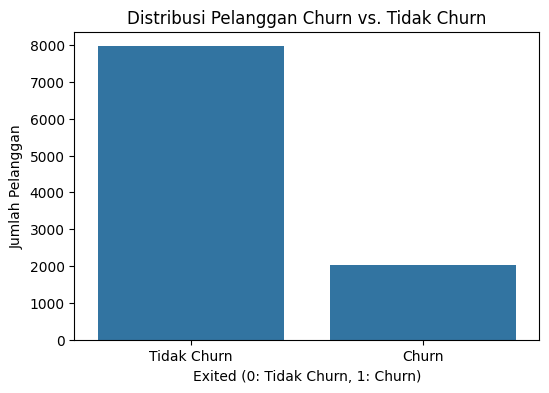

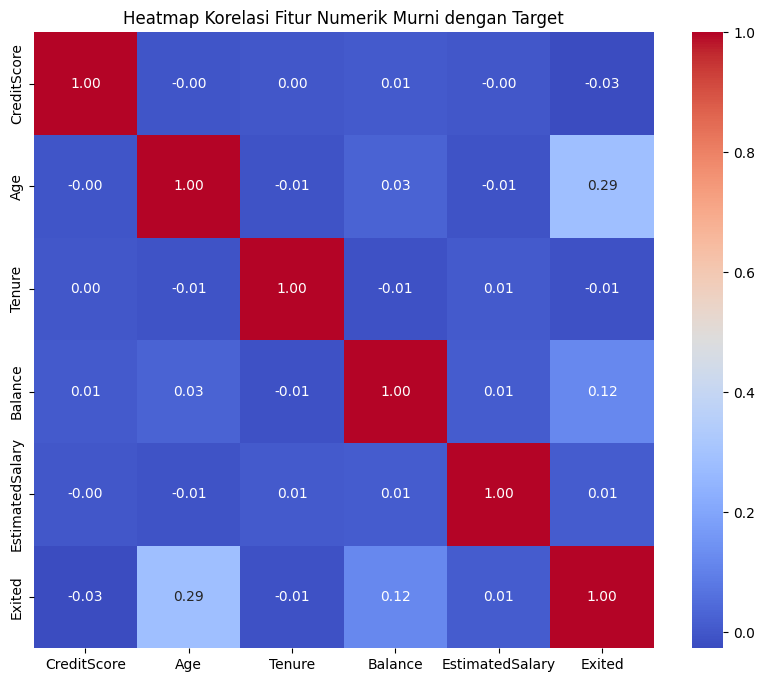

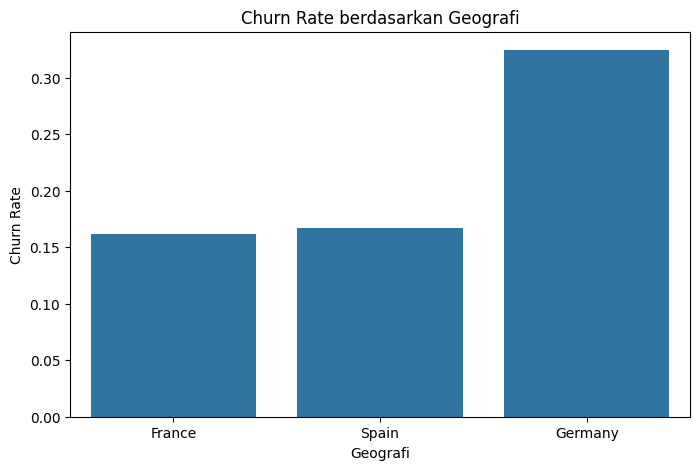

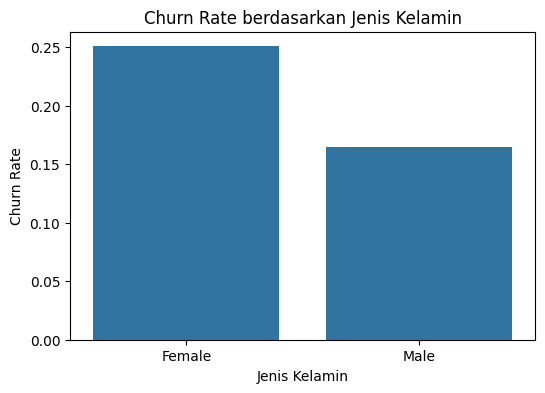

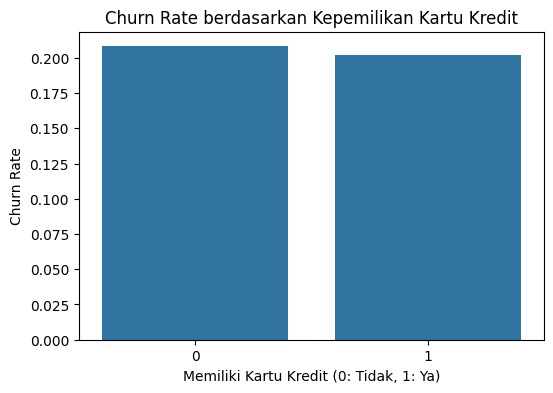

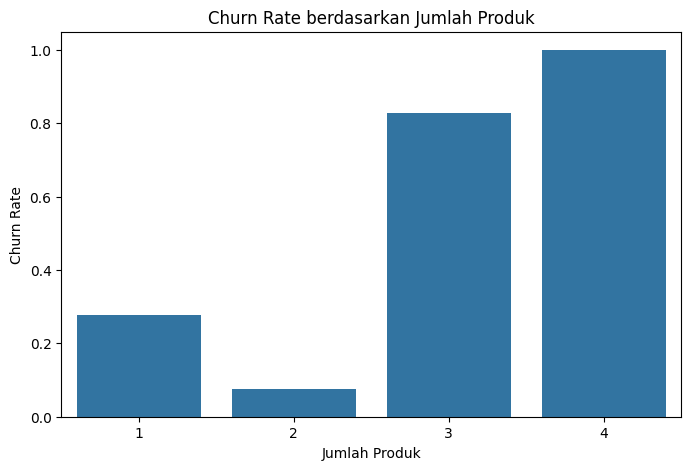

In [53]:
# --- 3. Eksplorasi Data Awal (Initial Exploratory Data Analysis - EDA) ---

# Analisis distribusi variabel target (Exited)
print("\n--- Distribusi Variabel Target (Exited) ---")
print(df['Exited'].value_counts())
print(df['Exited'].value_counts(normalize=True) * 100) # Persentase churn

# Visualisasi distribusi variabel target
plt.figure(figsize=(6, 4))
sns.countplot(x='Exited', data=df)
plt.title('Distribusi Pelanggan Churn vs. Tidak Churn')
plt.xlabel('Exited (0: Tidak Churn, 1: Churn)')
plt.ylabel('Jumlah Pelanggan')
plt.xticks([0, 1], ['Tidak Churn', 'Churn'])
plt.show()

# Visualisasi korelasi fitur numerik murni dengan 'Exited' (menggunakan heatmap)
# Sekarang hanya menggunakan fitur numerik murni
plt.figure(figsize=(10, 8))
sns.heatmap(df[numerical_features + ['Exited']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap Korelasi Fitur Numerik Murni dengan Target')
plt.show()

# Contoh visualisasi untuk fitur kategorikal vs. Churn
# Churn rate berdasarkan Geografi
plt.figure(figsize=(8, 5))
sns.barplot(x='Geography', y='Exited', data=df, errorbar=None)
plt.title('Churn Rate berdasarkan Geografi')
plt.xlabel('Geografi')
plt.ylabel('Churn Rate')
plt.show()

# Churn rate berdasarkan Jenis Kelamin
plt.figure(figsize=(6, 4))
sns.barplot(x='Gender', y='Exited', data=df, errorbar=None)
plt.title('Churn Rate berdasarkan Jenis Kelamin')
plt.xlabel('Jenis Kelamin')
plt.ylabel('Churn Rate')
plt.show()

# Churn rate berdasarkan HasCrCard (sekarang diperlakukan kategorikal)
plt.figure(figsize=(6, 4))
sns.barplot(x='HasCrCard', y='Exited', data=df, errorbar=None)
plt.title('Churn Rate berdasarkan Kepemilikan Kartu Kredit')
plt.xlabel('Memiliki Kartu Kredit (0: Tidak, 1: Ya)')
plt.ylabel('Churn Rate')
plt.show()

# Churn rate berdasarkan NumOfProducts (sekarang diperlakukan kategorikal)
plt.figure(figsize=(8, 5))
sns.barplot(x='NumOfProducts', y='Exited', data=df, errorbar=None)
plt.title('Churn Rate berdasarkan Jumlah Produk')
plt.xlabel('Jumlah Produk')
plt.ylabel('Churn Rate')
plt.show()


In [54]:
# --- 4. Persiapan Data untuk Model (Data Preparation for Modeling) ---

# Memisahkan fitur (X) dan variabel target (y)
X = df.drop('Exited', axis=1)
y = df['Exited']

# Pembagian data menjadi training dan testing set
# Penting: Lakukan stratifikasi pada 'y' karena dataset tidak seimbang
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nUkuran X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Ukuran X_test: {X_test.shape}, y_test: {y_test.shape}")
print(f"Distribusi y_train sebelum SMOTE:\n{y_train.value_counts()}")

# Preprocessing: Skala untuk fitur numerik dan One-Hot Encoding untuk fitur kategorikal
# Menggunakan ColumnTransformer untuk menerapkan transformasi yang berbeda pada kolom yang berbeda
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()) # Penskalaan standar untuk fitur numerik
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # One-Hot Encoding untuk fitur kategorikal
])

# Gabungkan transformer menggunakan ColumnTransformer
# Pastikan nama kolom di `numerical_features` dan `categorical_features` sesuai dengan `X_train`
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features), # Sekarang hanya fitur numerik murni
        ('cat', categorical_transformer, categorical_features) # Semua fitur kategorikal (termasuk 0/1 dan 1-4)
    ],
    remainder='passthrough' # Biarkan kolom lain jika ada (tidak ada dalam kasus ini)
)

# Terapkan preprocessor ke training data
# Perlu transformasi X_train sebelum SMOTE karena SMOTE bekerja pada data numerik
# fit_transform pada X_train untuk mempelajari transformasi dari data training
X_train_processed = preprocessor.fit_transform(X_train)

# Mendapatkan nama fitur setelah one-hot encoding
# Urutan nama fitur: numerik murni, lalu one-hot encoded kategorikal
onehot_feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
all_feature_names = numerical_features + onehot_feature_names.tolist()


Ukuran X_train: (8000, 10), y_train: (8000,)
Ukuran X_test: (2000, 10), y_test: (2000,)
Distribusi y_train sebelum SMOTE:
Exited
0    6370
1    1630
Name: count, dtype: int64


In [55]:
# Konversi kembali ke DataFrame untuk kemudahan penanganan dengan SMOTE
X_train_processed_df = pd.DataFrame(X_train_processed, columns=all_feature_names, index=X_train.index)

# --- 5. Penanganan Imbalance Data dengan SMOTE ---
print("\n--- Menerapkan SMOTE pada Training Data ---")
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed_df, y_train)

print(f"Original training dataset shape: {y_train.value_counts()}")
print(f"Resampled training dataset shape: {y_train_resampled.value_counts()}")


--- Menerapkan SMOTE pada Training Data ---
Original training dataset shape: Exited
0    6370
1    1630
Name: count, dtype: int64
Resampled training dataset shape: Exited
1    6370
0    6370
Name: count, dtype: int64


Setelah dilakukan .value_counts() pada kolom Exited (kolom yang berisi apakah customer churn dan tidak churn), terlihat bahwa
data antara label 1 (churn) jauh lebih sedikit dibandingkan dengan label 0 (tidak churn), sehingga dataset tidak seimbang (imbalanced).

Ada dua pendekatan umum untuk mengatasi hal ini, yaitu undersampling dan oversampling.
- Undersampling: mengurangi jumlah data pada kelas mayoritas (0) agar seimbang dengan kelas minoritas (1).
- Oversampling: menambah jumlah data pada kelas minoritas (1), misalnya dengan teknik SMOTE atau random oversampling.

Untuk kasus churn prediction, oversampling lebih disarankan karena:
- Data minoritas (churn) biasanya lebih penting untuk dipelajari oleh model.
- Undersampling bisa menyebabkan hilangnya informasi penting dari data mayoritas

In [56]:
# --- 6. Membangun dan Melatih Model (Building and Training the Model) ---

# Model akan dilatih pada data yang sudah di-resample
# Menggunakan Logistic Regression sebagai model dasar
# model_lr = Pipeline(steps=[
#     ('classifier', LogisticRegression(random_state=42, solver='liblinear'))
# ])

# Menggunakan Random Forest sebagai alternatif model yang lebih kuat
# Random Forest cenderung bekerja baik dengan data tabular dan dapat menangani fitur non-linier
model_rf = Pipeline(steps=[
    ('classifier', RandomForestClassifier(random_state=42, n_estimators=100)) # n_estimators: jumlah pohon dalam forest
])

# Pilih model yang ingin Anda gunakan:
final_model = model_rf # Atau model_lr

print(f"\n--- Melatih Model {final_model.named_steps['classifier'].__class__.__name__} pada Data Resampled ---")
final_model.fit(X_train_resampled, y_train_resampled)
print(f"Model {final_model.named_steps['classifier'].__class__.__name__} berhasil dilatih!")


--- Melatih Model RandomForestClassifier pada Data Resampled ---
Model RandomForestClassifier berhasil dilatih!



--- Metrik Evaluasi Model (RandomForestClassifier) ---
Accuracy: 0.8440
Precision: 0.6240
Recall: 0.5872
F1-Score: 0.6051
AUC-ROC: 0.8419

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.90      0.91      0.90      1593
           1       0.62      0.59      0.61       407

    accuracy                           0.84      2000
   macro avg       0.76      0.75      0.75      2000
weighted avg       0.84      0.84      0.84      2000


--- Confusion Matrix ---
[[1449  144]
 [ 168  239]]


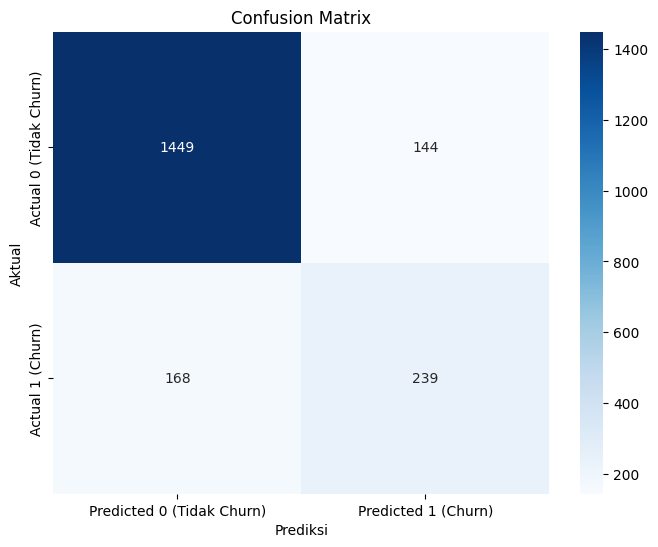

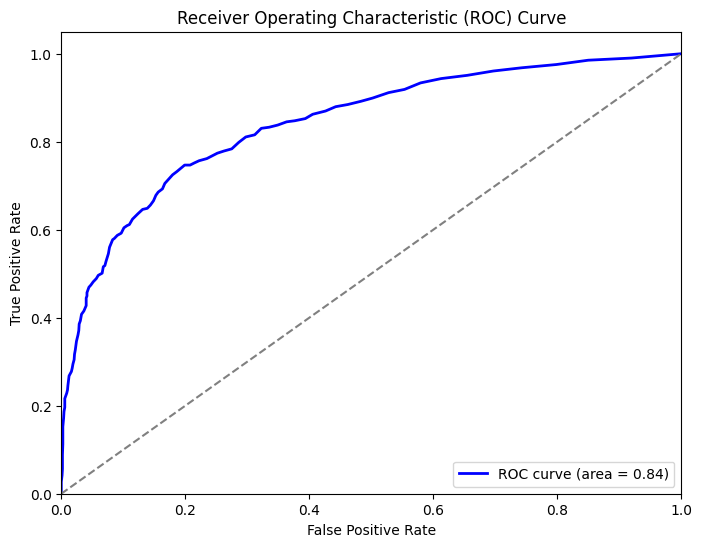

In [57]:
# --- 7. Evaluasi Model (Model Evaluation) ---

# Pertama, terapkan preprocessor ke test data
# transform pada X_test untuk menggunakan transformasi yang dipelajari dari data training
X_test_processed = preprocessor.transform(X_test)
X_test_processed_df = pd.DataFrame(X_test_processed, columns=all_feature_names, index=X_test.index)

# Membuat prediksi pada test set (data yang tidak di-resample)
y_pred = final_model.predict(X_test_processed_df)
y_proba = final_model.predict_proba(X_test_processed_df)[:, 1] # Probabilitas kelas positif (churn)

print(f"\n--- Metrik Evaluasi Model ({final_model.named_steps['classifier'].__class__.__name__}) ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_proba):.4f}")

# Classification Report (memberikan detail precision, recall, f1-score per kelas)
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\n--- Confusion Matrix ---")
print(cm)

# Visualisasi Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0 (Tidak Churn)', 'Predicted 1 (Churn)'],
            yticklabels=['Actual 0 (Tidak Churn)', 'Actual 1 (Churn)'])
plt.title('Confusion Matrix')
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.show()

# Kurva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_score(y_test, y_proba):.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


--- Feature Importance (Random Forest) ---
              Feature  Importance
1                 Age    0.236014
3             Balance    0.114557
15    NumOfProducts_2    0.104981
4     EstimatedSalary    0.096876
0         CreditScore    0.092622
2              Tenure    0.081526
14    NumOfProducts_1    0.057959
6   Geography_Germany    0.039096
13   IsActiveMember_1    0.028293
12   IsActiveMember_0    0.024762


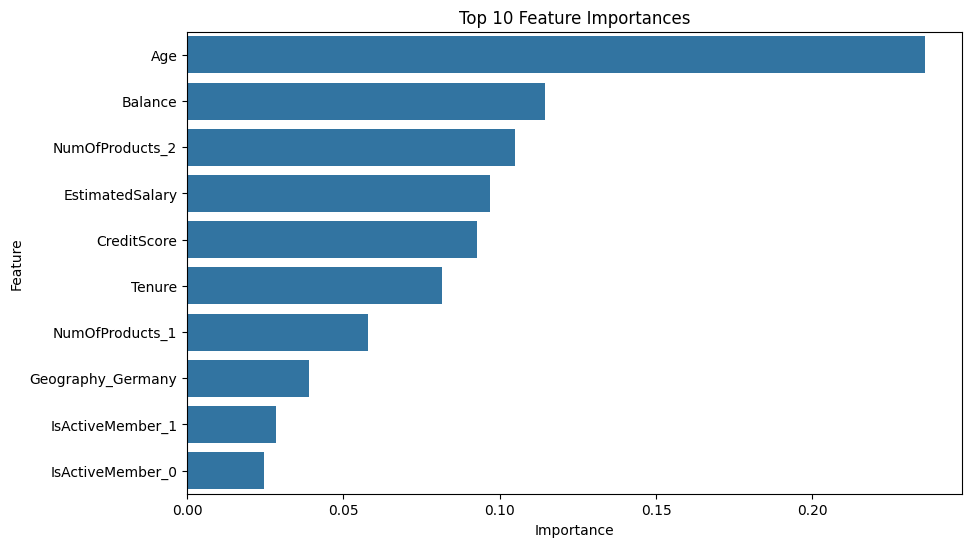

In [58]:
# --- 8. Interpretasi Model (Opsional, untuk Random Forest/XGBoost) ---
# Jika Anda menggunakan model berbasis pohon seperti Random Forest, Anda bisa mendapatkan feature importance
if isinstance(final_model.named_steps['classifier'], RandomForestClassifier):
    print("\n--- Feature Importance (Random Forest) ---")
    importances = final_model.named_steps['classifier'].feature_importances_
    feature_names = all_feature_names # Gunakan nama fitur yang sudah diproses
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    print(feature_importance_df.head(10))

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))
    plt.title('Top 10 Feature Importances')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()